In [3]:
#!pip install torchvision

### load data

In [1]:
from torchvision import datasets
from torch.utils.data import random_split, ConcatDataset


data_train = datasets.STL10(root="data", split="train", download=True)
data_test = datasets.STL10(root="data", split="test", download=True)

extra_train_len = 4000
remaining_test_len = len(data_test) - extra_train_len

extra_train, data_test = random_split(data_test, [extra_train_len, remaining_test_len])

data_train = ConcatDataset([data_train, extra_train])


val_len = 2000
test_len = len(data_test) - val_len
data_val, data_test = random_split(data_test, [val_len, test_len])


print(f"Tamaño set de entrenamiento: {len(data_train)}")
print(f"Tamaño set de validación:    {len(data_val)}")
print(f"Tamaño set de test:          {len(data_test)}")

Tamaño set de entrenamiento: 9000
Tamaño set de validación:    2000
Tamaño set de test:          2000


In [2]:
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, dataset, train=True):
        self.dataset = dataset

        if train:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)

        return image, label

In [3]:
dataset_train = ImageDataset(data_train)
dataset_test = ImageDataset(data_test)
dataset_val = ImageDataset(data_val)

print(f"Tamaño set de entrenamiento: {len(dataset_train)}")
print(f"Tamaño set de validación:    {len(dataset_val)}")
print(f"Tamaño set de test:        {len(dataset_test)}")

Tamaño set de entrenamiento: 9000
Tamaño set de validación:    2000
Tamaño set de test:        2000


In [4]:
idx = 200
img, lbl = dataset_train[idx]
print(f"Tipo de dato imagen: {type(img)}")
print(f"Máximo/mínimo imagen: {img.min()}/{img.max()}")
print(f"Tamaño imagen: {img.size()}")
print(f"Etiqueta imagen: {lbl}")

Tipo de dato imagen: <class 'torch.Tensor'>
Máximo/mínimo imagen: -1.0/0.5058823823928833
Tamaño imagen: torch.Size([3, 96, 96])
Etiqueta imagen: 0


### Train model

In [5]:
from torch import nn
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

In [6]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando la GPU")
else:
    device = torch.device("cpu")
    print("Usando la CPU")

Usando la GPU


In [7]:
# 0. --------------------------------------------------

torch.manual_seed(35)

# 1. --------------------------------------------------

class CNNModel(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # ----------------------------
    # Convolutional Layer 1
    # input size: (96,96,3)
    # Config: kernel de 5x5, padding de 2 y stride de 1, al final activación ReLu
    # output size: (Input_size - Kernel_size + 2*Padding) / Stride + 1 -> (96 - 5 + 2*2)/1 +1 = 96 más 32 filtros -> [96,96,32]
    # ----------------------------
    # Max Pooling Layer 1
    # ----------------------------
    # input size = [96,96,32]
    # Config: max pooling con kernel de 5x5 más stride de 1
    # output size = (Input_size - Kernel_size)/ stride + 1 -> (96-5)/1 + 1 = 92 -> (92,92,32)

    self.conv1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.GELU(),
    nn.MaxPool2d(kernel_size=5, stride=1)
    )

    # ----------------------------
    # Convolutional Layer 2
    # input size: (92,92,32)
    # Config: kernel de 4x4, padding de 0 y stride de 1, al final activación GELU
    # output size: (Input_size - Kernel_size + 2*Padding) / Stride + 1 -> (92 - 4 + 2*0)/1 +1 = 89 más 64 filtros -> [89,89,64]
    # ----------------------------
    # Max Pooling Layer 1
    # ----------------------------
    # input size = [89,89,64]
    # Config: max pooling con kernel de 5x5 más stride de 1
    # output size = (Input_size - Kernel_size)/ stride + 1 -> (89-5)/2 + 1 = 33 -> (43,43,64)

    self.conv2 = nn.Sequential(
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=0),
    nn.GELU(),
    nn.MaxPool2d(kernel_size=5, stride=2)
    )

    # ----------------------------
    # Capas fully conected
    # ----------------------------

    self.fc1 = torch.nn.Linear(43*43*64, 512)
    self.relu3 = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(0.2)
    self.fc3 = nn.Linear(512, 10)

  def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = x.reshape(x.shape[0], 43*43*64)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [8]:
# 3.
model = CNNModel()

EPOCHS = 15
lr = 0.001
l2 = 1e-3
BATCH_SIZE = 64
perdida = nn.CrossEntropyLoss()
optimizador = optim.AdamW(model.parameters(), lr=lr)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
def train_nn(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    total_loss = 0
    model.train()
    model.to(device)


    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    total_loss = total_loss / len(dataloader)
    print(f"train_loss: {total_loss:>8f}")
    return total_loss


def validate_nn(dataloader, model, loss_fn, device):
    model.eval()
    model.to(device)
    size = len(dataloader.dataset)
    n_lotes = len(dataloader)
    total_loss, aciertos = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)

            total_loss += loss_fn(pred, y).item()

            aciertos += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss = total_loss/n_lotes
    aciertos /= size
    print(f"val_loss: {val_loss:>8f}")
    print(f"Error validación (Accuracy): {(100*aciertos):>0.1f}")

    return val_loss

In [10]:
train_losses = [] ## esto es para acumular las perdidas y graficar despues
val_losses = []
print(f"Training for {EPOCHS} Epochs using {device}")
print(f"\n")
for t in range(EPOCHS):
    print(f"Epoch {t+1}/{EPOCHS}\n")
    train_loss = train_nn(dataloader_train, model, perdida, optimizador, device)
    val_loss = validate_nn(dataloader_val, model, perdida, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"-------------------------------\n")

Training for 15 Epochs using cuda


Epoch 1/15

train_loss: 1.880915
val_loss: 1.559369
Error validación (Accuracy): 43.4
-------------------------------

Epoch 2/15

train_loss: 1.541891
val_loss: 1.365641
Error validación (Accuracy): 51.1
-------------------------------

Epoch 3/15

train_loss: 1.407902
val_loss: 1.271649
Error validación (Accuracy): 54.9
-------------------------------

Epoch 4/15

train_loss: 1.369674
val_loss: 1.276094
Error validación (Accuracy): 53.3
-------------------------------

Epoch 5/15

train_loss: 1.339077
val_loss: 1.255473
Error validación (Accuracy): 54.3
-------------------------------

Epoch 6/15

train_loss: 1.272700
val_loss: 1.239173
Error validación (Accuracy): 56.2
-------------------------------

Epoch 7/15

train_loss: 1.270560
val_loss: 1.179348
Error validación (Accuracy): 57.9
-------------------------------

Epoch 8/15

train_loss: 1.223532
val_loss: 1.148823
Error validación (Accuracy): 58.8
-------------------------------

Epoch 9/15



### Eval model

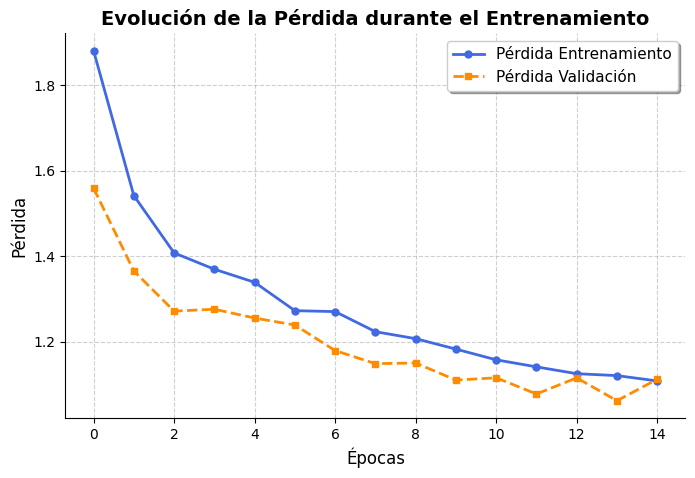

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))

plt.plot(train_losses, label='Pérdida Entrenamiento', color='royalblue', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Pérdida Validación', color='darkorange', linewidth=2, linestyle='--', marker='s', markersize=5)

plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.title('Evolución de la Pérdida durante el Entrenamiento', fontsize=14, fontweight='bold')


plt.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)


plt.grid(True, linestyle='--', alpha=0.6)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

In [13]:
def calcular_acc(model, dataloader, device):
    model.eval()
    aciertos = 0


    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            preds = model(x)


            aciertos += (preds.argmax(1) == y).type(torch.float).sum().item()


    exactitud = aciertos / len(dataloader.dataset)
    return exactitud

In [14]:
acc_train = calcular_acc(model, dataloader_train, device)
acc_val = calcular_acc(model, dataloader_val, device)
acc_test = calcular_acc(model, dataloader_test, device)

print(f"Accuracy Train {100*acc_train:.6f}%")
print(f"Accuracy val {100*acc_val:.6f}%")
print(f"Accuracy Test {100*acc_test:.6f}%")

Accuracy Train 65.277778%
Accuracy val 61.700000%
Accuracy Test 58.750000%
